# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

In [3]:
# Load EMNIST dataset
# import tensorflow_datasets as tfds
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data('letters')
import tensorflow_datasets as tfds
(train, test), dataset_info = tfds.load(
  'emnist/byclass',
  split=['train', 'test'],
  as_supervised=True,
  with_info=True,
)
def preprocess_images(image, label):
    # Convert to float and normalize to [0, 1]
    # This is important because neural networks work better with normalized data
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.flip_left_right(image)
    image = tf.image.rot90(image)
    return image, label
train = train.map(preprocess_images)
test = test.map(preprocess_images)
x_train = []
y_train = []
for image, label in tfds.as_numpy(train.take(1000)):
    x_train.append(image)
    y_train.append(label)
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = []
y_test = []
for image, label in tfds.as_numpy(test.take(1000)):
    x_test.append(image)
    y_test.append(label)
x_test = np.array(x_test)
y_test = np.array(y_test)
temp = x_train[0].T
display(temp)
display(temp.shape)

2025-05-14 11:54:55.007970: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-14 11:54:55.008019: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-14 11:54:55.008028: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1747248895.008326 15040604 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747248895.008353 15040604 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-14 11:54:55.496503: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-14 11:54:55.613137: I tensorflow/core/framework/local_rendezvous.c

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00784314, 0.01176471,
         0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.

(1, 28, 28)

Training data shape: (1000, 28, 28, 1)
Test data shape: (1000, 28, 28, 1)
Number of classes: 62


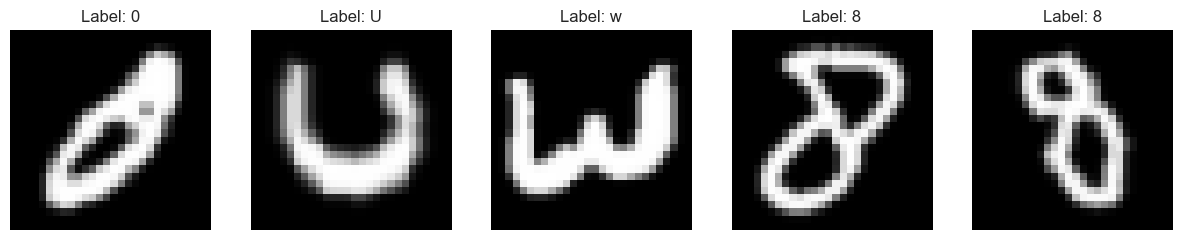

In [4]:
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    k =np.random.randint(0, len(x_train) - 1)
    plt.imshow(x_train[k], cmap='gray')
    plt.title(f'Label: {chr(y_train[k] + (ord('0') if y_train[k] < 10 else( ord("A") - 10 if y_train[k] < 36 else ord("a") - 36)))}')
    plt.axis('off')
plt.show()

In [ ]:
# Preprocess data
# Normalize pixel values
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

## 2. Model Implementation

### TensorFlow/Keras Implementation

In [ ]:
# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    """
    Create a CNN using TensorFlow/Keras.
    
    Requirements:
    - Must use at least 2 convolutional layers
    - Must include pooling and batch normalization
    - Must use categorical crossentropy loss
    
    Goals:
    - Achieve > 85% accuracy on test set
    - Minimize overfitting using batch normalization and dropout
    - Train efficiently with appropriate batch size and learning rate
    
    Args:
        input_shape: Shape of input data (should be (28, 28, 1) for grayscale images)
        num_classes: Number of output classes (26 for letters)
    
    Returns:
        Compiled Keras model
    """
    model = tf.keras.Sequential([...])
    
    model.compile(...)
    
    return model

# Create and compile model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()

### PyTorch Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        """
        Create a CNN using PyTorch.
        
        Requirements:
        - Must use at least 2 convolutional layers
        - Must include pooling and batch normalization
        
        Goals:
        - Achieve > 85% accuracy on test set
        - Minimize overfitting using batch normalization and dropout
        - Train efficiently with appropriate batch size and learning rate
        
        Args:
            num_classes: Number of output classes (26 for letters)
        """
        super(CNN, self).__init__()
        [...]
    
    def forward(self, x):
        """
        Forward pass of the network.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
        
        Returns:
            Output tensor of shape (batch_size, num_classes)
        """
        [...]
        return x

# Create model
model = CNN(num_classes=26)
print(model)

## 3. Training and Evaluation

### TensorFlow/Keras Training

In [ ]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# Train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Training')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history.history['loss'], label='Training')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

### PyTorch Training

In [ ]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Convert data to PyTorch tensors
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(np.argmax(y_train, axis=1)).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.LongTensor(np.argmax(y_val, axis=1)).to(device)

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(20):
    # Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    
    for i in range(0, len(x_train), 32):
        batch_x = x_train[i:i+32]
        batch_y = y_train[i:i+32]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()
    
    train_loss = train_loss / (len(x_train) / 32)
    train_acc = train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for i in range(0, len(x_val), 32):
            batch_x = x_val[i:i+32]
            batch_y = y_val[i:i+32]
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()
    
    val_loss = val_loss / (len(x_val) / 32)
    val_acc = val_correct / val_total
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
        # Save architecture
        with open('models/cnn_pytorch_arch.txt', 'w') as f:
            f.write(str(model))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history['train_acc'], label='Training')
ax1.plot(history['val_acc'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot loss
ax2.plot(history['train_loss'], label='Training')
ax2.plot(history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for CNN input
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create CNN with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in CNN layers
   - Solution: Ensure data is properly shaped (samples, height, width, channels)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters